# Table of contents

### 1. Importing libraries
### 2. Importing data
### 3. Considering security implications
### 4. Creating regional segmentation of the data
### 5. Creating exclusion flag for low revenue customers
### 6. Creating new profiling variable for customers
### 7. Creating visualization to show profile distribution
### 8. Aggregating customer-profile for usage frequency and expenditure
### 9. Compare your customer profiles with regions and departments
### 10. Producing and exporting charts
### 11. Exporting dataset

# 1. Importing libraries

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

# 2. Importing data

In [2]:
# Set path to project folder

path = r'/Users/tknoepfli/Documents/CareerFoundry/Instacart Basket Analysis'

In [3]:
# Import dataframe

df = pd.read_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'ords_prods_cust_merged.pkl'))

In [4]:
# Check shape of dataframe

df.shape

(32429362, 33)

In [5]:
# Change settings to display all columns in dataframe

pd.set_option('display.max_columns', None)

In [ ]:
# Display head of all dataframe columns

df.head()

In [7]:
# Adding column "department" based on "department_id" for analyses below

df_depts = pd.read_csv(os.path.join(path, '02 Data', 'Prepared Data', 'departments_wrangled.csv'), index_col = False)
df_depts.rename(columns = {'Unnamed: 0' : 'department_id'}, inplace = True)
data_dict = dict(zip(df_depts.department_id, df_depts.department))
df['department_name'] = df['department_id'].map(data_dict)

# 3. Considering security implications for this data

The first_name and last_name columns in this dataset contain personally identifiable information (PII). In a real world scenario, I would reach out to the client to discuss the way forward in handling this data. For the sake of this exercise, I will drop both columns to make sure that the dataframe does not contain any PII.

In [8]:
# Drop "first_name" and "last_name" columns from dataframe

df.drop(columns = ['first_name', 'last_name'], inplace = True)

# 4. Creating regional segmentation of the data

In [9]:
# Create list of US regions

northeast = 'Maine', 'New Hampshire', 'Vermont', 'Massachusetts', 'Rhode Island', 'Connecticut', 'New York', 'Pennsylvania', 'New Jersey'
midwest = 'Wisconsin', 'Michigan', 'Illinois', 'Indiana', 'Ohio', 'North Dakota', 'South Dakota','Nebraska', 'Kansas', 'Minnesota', 'Iowa', 'Missouri'
south = 'Delaware', 'Maryland', 'District of Columbia', 'Virginia', 'West Virginia', 'North Carolina', 'South Carolina', 'Georgia', 'Florida', 'Kentucky', 'Tennessee', 'Mississippi', 'Alabama', 'Oklahoma', 'Texas', 'Arkansas', 'Louisiana'
west = 'Idaho', 'Montana', 'Wyoming', 'Nevada', 'Utah', 'Colorado', 'Arizona', 'New Mexico', 'Alaska', 'Washington', 'Oregon', 'California', 'Hawaii'

In [10]:
# Create new "region" column based on "state"

df.loc[df['state'].isin(northeast), 'region'] = 'Northeast'
df.loc[df['state'].isin(midwest), 'region'] = 'Midwest'
df.loc[df['state'].isin(south), 'region'] = 'South'
df.loc[df['state'].isin(west), 'region'] = 'West'

In [11]:
# Check new column for NaN values

df['region'].value_counts(dropna = False)

South        10800007
West          8299247
Midwest       7602601
Northeast     5727507
Name: region, dtype: int64

In [12]:
# Check spending per region

df.groupby(['region'])['spending_flag'].agg(pd.Series.mode)

region
Midwest      Low spender
Northeast    Low spender
South        Low spender
West         Low spender
Name: spending_flag, dtype: object

All regions have a majority of low spenders. A crosstab is useful to take a closer look.

In [13]:
# Create crosstab to compare spending per region

pd.crosstab(df['region'], df['spending_flag'], dropna = False)

spending_flag,High spender,Low spender
region,,
Midwest,29298,7573303
Northeast,18659,5708848
South,40641,10759366
West,31271,8267976


In [14]:
# Display crosstab in percentages

pd.crosstab(df['region'], df['spending_flag']).apply(lambda r: r/r.sum(), axis=1)

spending_flag,High spender,Low spender
region,,
Midwest,0.003854,0.996146
Northeast,0.003258,0.996742
South,0.003763,0.996237
West,0.003768,0.996232


The spending habits do not vary dramatically by region. The South is the biggest market and thus has the highest absolute number of high spenders, however the Midwest has the highest percentage of high spenders.

# 5. Creating exclusion flag for low revenue customers

In [15]:
# Create exclusion flag for customers with less than five orders

df.loc[df['max_order'] < 5, 'exclusion_flag'] = 'exclude'
df.loc[df['max_order'] >= 5, 'exclusion_flag'] = 'include'

In [16]:
df['exclusion_flag'].value_counts(dropna = False)

include    30988089
exclude     1441273
Name: exclusion_flag, dtype: int64

In [17]:
df.head()

,order_id,user_id,order_number,order_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,prices,price_range_loc,busiest_day,busiest_day_2,busiest_period_of_day,max_order,loyalty_flag,spender_type,spending_flag,median_order_frequency,customer_frequency_flag,gender,state,age,date_joined,number_of_dependents,marital_status,income,merge,department_name,region,exclusion_flag
0,2539329,1,1,2,8,NaN,196,1,0,Soda,77.0,7.0,9.0,Mid range product,Regularly busy,Regular days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,both,beverages,South,include
1,2539329,1,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,12.5,Mid range product,Regularly busy,Regular days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,both,dairy eggs,South,include
2,2539329,1,1,2,8,NaN,12427,3,0,Original Beef Jerky,23.0,19.0,4.4,Low range product,Regularly busy,Regular days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,both,snacks,South,include
3,2539329,1,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23.0,19.0,4.7,Low range product,Regularly busy,Regular days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,both,snacks,South,include
4,2539329,1,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,1.0,Low range product,Regularly busy,Regular days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,both,household,South,include


In [18]:
# Save customers to be excluded from the dataframe based on "exclusion_flag"

df_low_activity_cust = df[df['exclusion_flag'] == 'exclude']

In [19]:
df_low_activity_cust.shape

(1441273, 34)

In [20]:
# Export sample of low activity customers

df_low_activity_cust.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'low_activity_customer_sample.pkl'))

In [21]:
# Drop low activity customers from ords_prods_cust dataframe

df = df.loc[df['exclusion_flag'] == 'include']

In [22]:
df.shape

(30988089, 34)

The dataframe's new shape shows that only the desired rows remain.

# 6. Creating new profiling variable for customers

I am creating five flags in a new dedicated columns as follows:

1. 'income_bracket': Low income (up to 40k USD)/Middle income (40k to 100k USD)/High income (100k + USD)
2. 'age_group': Young adult (18 - 30 years)/Middle age (31 to 64 years)/Senior (65+ years)
3. 'dependent_status': Dependents (1+ dependents)/No dependents (zero dependents)
3. 'baby_household': True (purchases from department_id 18)/False (no purchases from department_id 18)
4. 'weekend_shopper': True (purchases made on days 0 and 1)/False (no purchases made on days 0 and 1)
5. 'late_night_shopper': True (pruchases made between 10pm and 4am)/False (no purchases made between 10pm and 4am)

In [23]:
# Dropping columns not relevant for further analysis

df = df.drop(columns = ['merge', 'exclusion_flag'])

In [24]:
# Create customer flag "income_bracket" 

df.loc[df['income'] <40000, 'income_bracket'] = 'Low income'
df.loc[(df['income'] >=40000) & (df['income'] <100000) , 'income_bracket'] = 'Middle income'
df.loc[df['income'] >=100000, 'income_bracket'] = 'High income'

In [25]:
df['income_bracket'].value_counts()

Middle income    15159373
High income      14214962
Low income        1613754
Name: income_bracket, dtype: int64

In [26]:
# Create customer flag "age_group"

df.loc[df['age'] <30, 'age_group'] = 'Young adult'
df.loc[(df['age'] >=31) & (df['age'] <=64), 'age_group'] = 'Middle age'
df.loc[df['age'] >=65, 'age_group'] = 'Senior'

In [27]:
df['age_group'].value_counts()

Middle age     16477467
Senior          8201489
Young adult     5822108
Name: age_group, dtype: int64

In [28]:
# Create customer flag "dependent_status"

df.loc[df['number_of_dependents'] == 0, 'dependent_status'] = 'No dependents'
df.loc[df['number_of_dependents'] >+ 1, 'dependent_status'] = 'Dependents'

In [29]:
df['dependent_status'].value_counts()

Dependents       15517339
No dependents     7745918
Name: dependent_status, dtype: int64

In [30]:
# Create customer flag "baby_household"

df['baby_household'] = np.where(df['department_id'] == 18, True, False)

In [31]:
df['baby_household'].value_counts()

False    30577697
True       410392
Name: baby_household, dtype: int64

In [32]:
# Create customer flag "weekend_shopper"

df['weekend_shopper'] = np.where((df['order_day_of_week'] == 0) | (df['order_day_of_week'] == 1), True,False)

In [33]:
df['weekend_shopper'].value_counts()

False    19658849
True     11329240
Name: weekend_shopper, dtype: int64

In [34]:
# Create customer flag "late_night_shopper"

df['late_night_shopper'] = np.where(df['order_hour_of_day'].between(0,4) | (df['order_hour_of_day'].between(22,23)), True, False)

In [35]:
df['late_night_shopper'].value_counts()

False    29512582
True      1475507
Name: late_night_shopper, dtype: int64

# 7. Creating visualization to show distribution of profiles

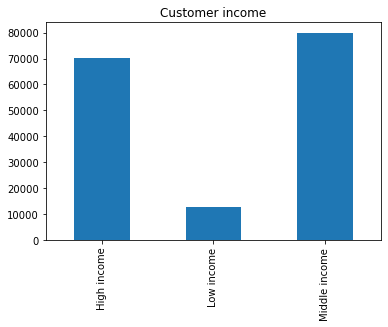

In [36]:
# Create a bar chart of the "income bracket" profile

bar_1 = df.groupby('income_bracket')['user_id'].nunique().plot.bar(title = 'Customer income', xlabel = '')

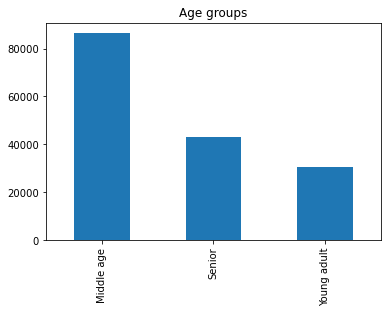

In [37]:
# Create a bar chart of the "age group" profile

bar_2 = df.groupby('age_group')['user_id'].nunique().plot.bar(title = 'Age groups', xlabel = '')

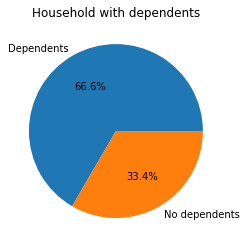

In [38]:
# Create a pie chart for the "dependent status" profile

pie_1 = df.groupby('dependent_status')['user_id'].nunique().plot.pie(legend=False, autopct='%1.1f%%', title = 'Household with dependents', ylabel = '')

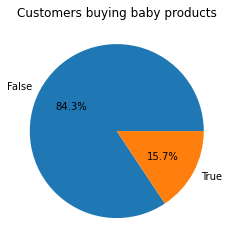

In [39]:
# Create a pie chart for the "baby household" profile

pie_2 = df.groupby('baby_household')['user_id'].nunique().plot.pie(legend=False, autopct='%1.1f%%', title = 'Customers buying baby products', ylabel ='')

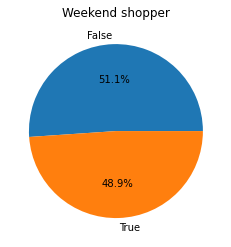

In [40]:
# Create a pie chart for the "weekend shopper" profile

pie_3 = df.groupby('weekend_shopper')['user_id'].nunique().plot.pie(legend=False, autopct='%1.1f%%', title = 'Weekend shopper', ylabel = '')

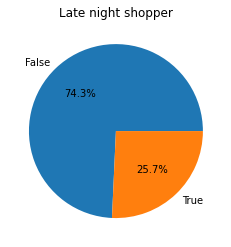

In [41]:
# Create a pie chart for the "late night shopper" profile

pie_4 = df.groupby('late_night_shopper')['user_id'].nunique().plot.pie(legend=False, autopct='%1.1f%%', title = 'Late night shopper', ylabel = '')

# 8. Aggregating customer-profile for usage frequency and expenditure

In [42]:
# Create new df ordered by user_id

df_users = df.drop_duplicates(subset='user_id')

In [43]:
df_users.shape

(162633, 38)

In [44]:
# Check "customer profile" profile for "median order frequency" and prices" max, mean and min values

df_users.groupby('income_bracket').agg({'median_order_frequency': ['min', 'max', 'mean'], 'prices': ['min', 'max', 'mean']})

median_order_frequency                  prices                
                                  min   max       mean    min   max      mean
income_bracket                                                               
High income                       0.0  30.0  13.534866    1.0  25.0  8.251467
Low income                        0.0  30.0  14.902416    1.0  25.0  6.219159
Middle income                     0.0  30.0  13.783754    1.0  25.0  7.869825

In [45]:
# Check "age group" profile for "median order frequency" and prices" max, mean and min values

df_users.groupby('age_group').agg({'median_order_frequency': ['min', 'max', 'mean'], 'prices': ['min', 'max', 'mean']})

median_order_frequency                  prices                
                               min   max       mean    min   max      mean
age_group                                                                 
Middle age                     0.0  30.0  13.781371    1.0  25.0  7.902150
Senior                         0.0  30.0  13.716879    1.0  25.0  7.933854
Young adult                    0.0  30.0  13.752979    1.0  25.0  7.878899

In [46]:
# Check "dependent status" profile for "median order frequency" and prices" max, mean and min values

df_users.groupby('dependent_status').agg({'median_order_frequency': ['min', 'max', 'mean'], 'prices': ['min', 'max', 'mean']})

median_order_frequency                  prices        \
                                    min   max       mean    min   max   
dependent_status                                                        
Dependents                          0.0  30.0  13.751681    1.0  25.0   
No dependents                       0.0  30.0  13.767310    1.0  25.0   

                            
                      mean  
dependent_status            
Dependents        7.895292  
No dependents     7.899791

In [47]:
# Check "baby household" profile for "median order frequency" and prices" max, mean and min values

df_users.groupby('baby_household').agg({'median_order_frequency': ['min', 'max', 'mean'], 'prices': ['min', 'max', 'mean']})

median_order_frequency                  prices                
                                  min   max       mean    min   max      mean
baby_household                                                               
False                             0.0  30.0  13.772375    1.0  25.0  7.905563
True                              1.0  30.0  12.467584    1.1  15.0  7.983659

In [48]:
# Check "weekend shopper" profile for "median order frequency" and prices" max, mean and min values

df_users.groupby('weekend_shopper').agg({'median_order_frequency': ['min', 'max', 'mean'], 'prices': ['min', 'max', 'mean']})

median_order_frequency                  prices                
                                   min   max       mean    min   max      mean
weekend_shopper                                                               
False                              0.0  30.0  13.672750    1.0  25.0  7.883199
True                               0.0  30.0  13.926734    1.0  25.0  7.947415

In [49]:
# Check "late night shopper" profile for "median order frequency" and prices" max, mean and min values

df_users.groupby('late_night_shopper').agg({'median_order_frequency': ['min', 'max', 'mean'], 'prices': ['min', 'max', 'mean']})

median_order_frequency                  prices        \
                                      min   max       mean    min   max   
late_night_shopper                                                        
False                                 0.0  30.0  13.758255    1.0  25.0   
True                                  0.0  30.0  13.864166    1.0  25.0   

                              
                        mean  
late_night_shopper            
False               7.907742  
True                7.873661

# 9. Compare your customer profiles with regions and departments

In [50]:
# Compare "income bracket" with "region"

pd.crosstab(df_users['income_bracket'], df_users['region'], margins=True,  normalize='index')

region,Midwest,Northeast,South,West
income_bracket,,,,
High income,0.239102,0.176491,0.330437,0.253970
Low income,0.232317,0.178059,0.332673,0.256950
Middle income,0.233807,0.174714,0.335765,0.255715
All,0.235973,0.175739,0.333229,0.255059


In [51]:
# Compare "income bracket" with "department"

pd.crosstab(df_users['income_bracket'], df_users['department_id'], margins=True,  normalize='index')

department_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
income_bracket,,,,,,,,,,,,,,,,,,,,,
High income,0.063176,0.001715,0.038197,0.280899,0.014276,0.006602,0.121608,0.004187,0.016905,0.000829,0.016948,0.026051,0.045085,0.017348,0.019434,0.203961,0.028166,0.007459,0.057017,0.029409,0.000729
Low income,0.059556,0.001665,0.030531,0.225535,0.015940,0.004837,0.173910,0.003727,0.011657,0.001269,0.016336,0.008485,0.038937,0.020619,0.015940,0.165424,0.030214,0.004362,0.146947,0.023394,0.000714
Middle income,0.062717,0.001604,0.037698,0.271489,0.013180,0.006803,0.130696,0.004272,0.016462,0.000940,0.016174,0.022739,0.044902,0.018930,0.019131,0.194741,0.027512,0.006878,0.073892,0.028577,0.000664
All,0.062669,0.001656,0.037357,0.271976,0.013866,0.006564,0.130135,0.004193,0.016280,0.000917,0.016520,0.023059,0.044518,0.018380,0.019014,0.196437,0.028004,0.006933,0.072293,0.028533,0.000696


The different income profiles are quite evenly spread by region. Certain interesting differences in spending habits become evident, for example that the low income profile spends a lower percentage of its overall expenses on produce and meat/seafood. Meanwhile, the high income bracket spends the highest percentage on meat/seafood. 

In [52]:
# Compare "age group" with "region"

pd.crosstab(df_users['age_group'], df_users['region'], margins=True,  normalize='index')

region,Midwest,Northeast,South,West
age_group,,,,
Middle age,0.237922,0.176575,0.331628,0.253875
Senior,0.235121,0.175260,0.333711,0.255908
Young adult,0.232486,0.173196,0.337997,0.256321
All,0.236133,0.175578,0.333400,0.254889


In [53]:
# Compare "age group" with "department"

pd.crosstab(df_users['age_group'], df_users['department_id'], margins=True,  normalize='index')

department_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
age_group,,,,,,,,,,,,,,,,,,,,,
Middle age,0.063376,0.001611,0.036690,0.271461,0.013586,0.006561,0.130601,0.004231,0.016797,0.000811,0.016624,0.022860,0.044782,0.018247,0.018386,0.196724,0.028170,0.006735,0.072696,0.028459,0.000591
Senior,0.060320,0.001783,0.038114,0.273144,0.013963,0.006321,0.131130,0.004075,0.015491,0.000903,0.016232,0.023758,0.044297,0.019381,0.019080,0.196152,0.027694,0.007086,0.071389,0.028829,0.000857
Young adult,0.064027,0.001681,0.038541,0.271735,0.014573,0.007055,0.127526,0.004319,0.016023,0.001220,0.016650,0.022254,0.043981,0.017606,0.020474,0.195641,0.028024,0.007023,0.072698,0.028156,0.000791
All,0.062674,0.001671,0.037426,0.271968,0.013875,0.006590,0.130160,0.004206,0.016297,0.000914,0.016523,0.022988,0.044499,0.018432,0.018970,0.196364,0.028014,0.006884,0.072343,0.028502,0.000701


Again, the different age profiles are quite evenly spread per region. Here, the spending habits by department are a lot more similar than observed above by income group.

In [54]:
# Compare "dependent status" with "region"

pd.crosstab(df_users['dependent_status'], df_users['region'], margins=True,  normalize='index')

region,Midwest,Northeast,South,West
dependent_status,,,,
Dependents,0.236099,0.174116,0.333814,0.255972
No dependents,0.234900,0.178133,0.332376,0.254591
All,0.235698,0.175458,0.333333,0.255511


In [55]:
# Compare "dependent status" with "department"

pd.crosstab(df_users['dependent_status'], df_users['department_id'], margins=True,  normalize='index')

department_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
dependent_status,,,,,,,,,,,,,,,,,,,,,
Dependents,0.062680,0.001480,0.037339,0.271718,0.013959,0.006363,0.131315,0.003860,0.016894,0.000937,0.016487,0.022936,0.044331,0.018423,0.018669,0.195659,0.028029,0.007078,0.072199,0.028880,0.000765
No dependents,0.065491,0.001918,0.037406,0.269515,0.012936,0.006812,0.128744,0.004501,0.016035,0.000959,0.016305,0.022945,0.042595,0.018346,0.019379,0.198588,0.027569,0.007157,0.073631,0.028552,0.000615
All,0.063619,0.001626,0.037361,0.270982,0.013617,0.006513,0.130457,0.004074,0.016607,0.000945,0.016426,0.022939,0.043751,0.018397,0.018907,0.196638,0.027875,0.007104,0.072678,0.028770,0.000715


Again, quite even distribution per region for the dependents profiles. Overall spending by department is similar too. One interesting datapoint here is the higher spending of the "No dependents" profile in the pet department.

In [56]:
# Compare "baby household" with "region"

pd.crosstab(df_users['baby_household'], df_users['region'], margins=True,  normalize='index')

region,Midwest,Northeast,South,West
baby_household,,,,
False,0.236064,0.175776,0.333082,0.255079
True,0.222913,0.170515,0.354352,0.252220
All,0.235973,0.175739,0.333229,0.255059


In [57]:
# Compare "baby household" with "department"

pd.crosstab(df_users['baby_household'], df_users['department_id'], margins=True,  normalize='index')

department_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
baby_household,,,,,,,,,,,,,,,,,,,,,
False,0.063107,0.001668,0.037617,0.273874,0.013963,0.006610,0.131044,0.004222,0.016394,0.000924,0.016635,0.023220,0.044828,0.018508,0.019147,0.197809,0.028199,0.000000,0.072798,0.028732,0.000701
True,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
All,0.062669,0.001656,0.037357,0.271976,0.013866,0.006564,0.130135,0.004193,0.016280,0.000917,0.016520,0.023059,0.044518,0.018380,0.019014,0.196437,0.028004,0.006933,0.072293,0.028533,0.000696


Here we observe a higher percentage of households with babies in the South, but slightly lower in the other regions. Because this profile was created by selecting customers based on spending in department 18 (baby category), no meaningful comparison by department is possible for this flag.

In [58]:
# Compare "weekend shopper" with "region"

pd.crosstab(df_users['weekend_shopper'], df_users['region'], margins=True,  normalize='index')

region,Midwest,Northeast,South,West
weekend_shopper,,,,
False,0.235852,0.177090,0.332196,0.254863
True,0.236192,0.173304,0.335092,0.255413
All,0.235973,0.175739,0.333229,0.255059


In [59]:
# Compare "weekend shopper" with "department"

pd.crosstab(df_users['weekend_shopper'], df_users['department_id'], margins=True,  normalize='index')

department_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
weekend_shopper,,,,,,,,,,,,,,,,,,,,,
False,0.064310,0.001761,0.037003,0.259564,0.016214,0.006681,0.134706,0.004489,0.016338,0.000861,0.017267,0.022091,0.046363,0.018501,0.018875,0.194297,0.029049,0.007255,0.075805,0.027852,0.000718
True,0.059711,0.001467,0.037995,0.294360,0.009632,0.006353,0.121891,0.003660,0.016175,0.001018,0.015174,0.024806,0.041188,0.018160,0.019265,0.200297,0.026118,0.006353,0.065960,0.029761,0.000656
All,0.062669,0.001656,0.037357,0.271976,0.013866,0.006564,0.130135,0.004193,0.016280,0.000917,0.016520,0.023059,0.044518,0.018380,0.019014,0.196437,0.028004,0.006933,0.072293,0.028533,0.000696


Again very similar distribution by region for the weekend shoppers. Perhaps surprisingly, a smaller percentage of weekend shopper's budget was spent in the alcohol department.

In [60]:
# Compare "late night shopper" with "region"

pd.crosstab(df_users['late_night_shopper'], df_users['region'], margins=True,  normalize='index')

region,Midwest,Northeast,South,West
late_night_shopper,,,,
False,0.236155,0.175395,0.333357,0.255093
True,0.232365,0.182563,0.330687,0.254385
All,0.235973,0.175739,0.333229,0.255059


In [61]:
# Compare "late night shopper" with "department"

pd.crosstab(df_users['late_night_shopper'], df_users['department_id'], margins=True,  normalize='index')

department_id,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,14.0,15.0,16.0,17.0,18.0,19.0,20.0,21.0
late_night_shopper,,,,,,,,,,,,,,,,,,,,,
False,0.062772,0.001669,0.037476,0.270804,0.014223,0.006597,0.130448,0.004217,0.016157,0.000906,0.016519,0.023214,0.044448,0.018356,0.019061,0.196435,0.027974,0.006914,0.072513,0.028595,0.000699
True,0.060625,0.001410,0.034991,0.295181,0.006793,0.005896,0.123943,0.003717,0.018713,0.001154,0.016534,0.019995,0.045886,0.018841,0.018072,0.196488,0.028582,0.007306,0.067931,0.027301,0.000641
All,0.062669,0.001656,0.037357,0.271976,0.013866,0.006564,0.130135,0.004193,0.016280,0.000917,0.016520,0.023059,0.044518,0.018380,0.019014,0.196437,0.028004,0.006933,0.072293,0.028533,0.000696


Finally, the Northeast sees a higher percentage of late night shopper profiles (so NYC truly really never sleeps). The late night shoppers spend a clearly lower percentage on alcohol and also less on snacks, which challenges my perception of would typically be ordered at that time of day. 

# 10. Producing and exporting charts

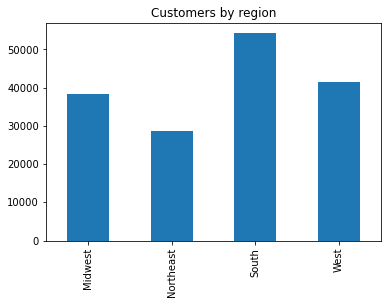

In [62]:
# Visualizing customer base by region as a bar chart

bar_3 = df_users.groupby('region')['user_id'].nunique().plot.bar(title = 'Customers by region', xlabel = '')

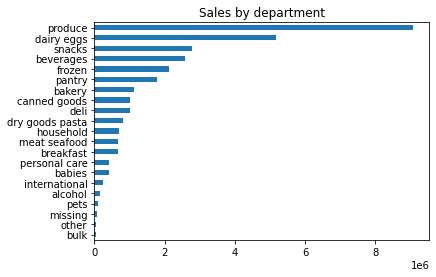

In [63]:
# Visualizing overall sales by department

barh_1 = df.department_name.value_counts().sort_values().plot.barh(title = 'Sales by department', xlabel = '')

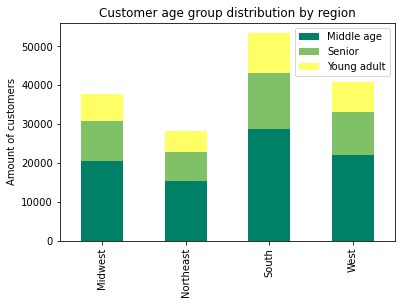

In [64]:
# Visualizing customer income profiles by region as stacked bar chart

region_income = pd.crosstab(df_users['region'], df_users['age_group'])
stacked_1 = region_income.plot(kind = 'bar', stacked = True, title = 'Customer age group distribution by region', ylabel = 'Amount of customers', xlabel = '', colormap = 'summer')
plt.legend(["Middle age", "Senior", "Young adult"])

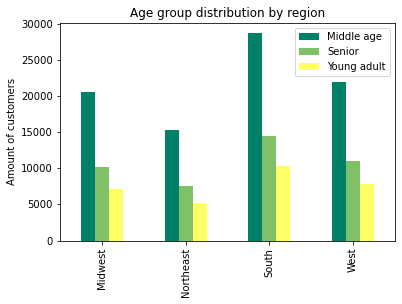

In [65]:
# Visualizing age/region crosstab as regular bar chart

region_age = pd.crosstab(df_users['region'], df_users['age_group'])
bar_4 = region_age.plot(kind = 'bar', title = 'Age group distribution by region', ylabel = 'Amount of customers', xlabel = '', colormap = 'summer')
plt.legend(["Middle age", "Senior", "Young adult"])

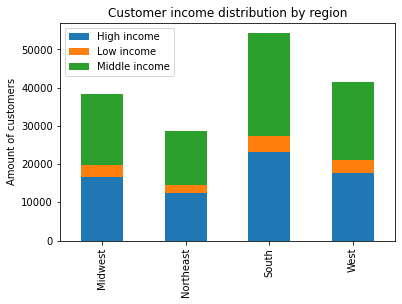

In [66]:
# Creating and visualizing crosstab of "region" and "income_bracket"

region_income = pd.crosstab(df_users['region'], df_users['income_bracket'])
stacked_2 = region_income.plot(kind = 'bar', stacked = True, title = 'Customer income distribution by region', ylabel = 'Amount of customers', xlabel = '')
plt.legend(["High income", "Low income", "Middle income"])

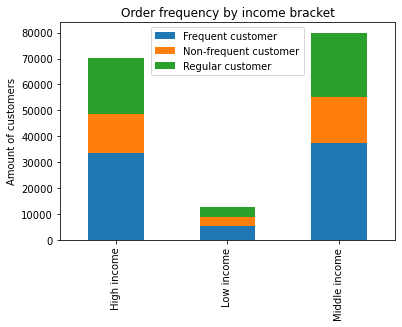

In [67]:
# Creating and visualizing a crosstab of "income bracket" and "customer frequency"

income_frequency = pd.crosstab(df_users['income_bracket'], df_users['customer_frequency_flag'])
stacked_3 = income_frequency.plot(kind = 'bar', stacked = True, title = 'Order frequency by income bracket', ylabel = 'Amount of customers', xlabel = '')
plt.legend(["Frequent customer", "Non-frequent customer", "Regular customer"])

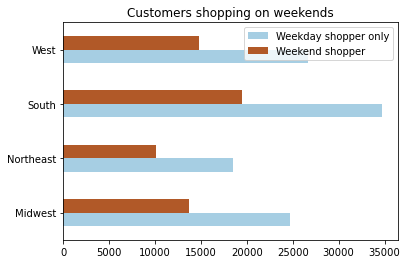

In [68]:
# Creating a horizontal bar chart of weekend customer profiles

income_frequency = pd.crosstab(df_users.region, df_users.weekend_shopper)
barh_2 = income_frequency.plot(kind = 'barh', title = 'Customers shopping on weekends', ylabel = 'Amount of customers', xlabel = '', colormap = 'Paired')
plt.legend(["Weekday shopper only", "Weekend shopper"])

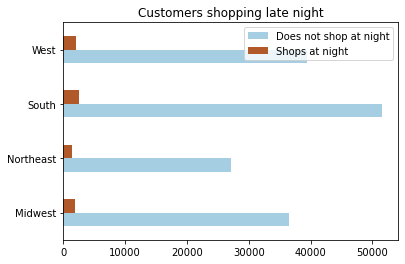

In [69]:
# Creating a horizontal bar chart of customers shopping late night

income_frequency = pd.crosstab(df_users.region, df_users.late_night_shopper)
barh_3 = income_frequency.plot(kind = 'barh', title = 'Customers shopping late night', ylabel = 'Amount of customers', xlabel = '', colormap = 'Paired')
plt.legend(["Does not shop at night", "Shops at night"])

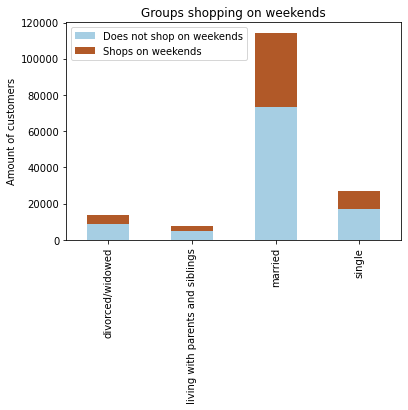

In [70]:
# Visualizing family groups that shop on weekends 

marital_weekend = pd.crosstab(df_users.marital_status, df_users.weekend_shopper)
stacked_4 = marital_weekend.plot(kind = 'bar', stacked = True, title = 'Groups shopping on weekends', ylabel = 'Amount of customers', xlabel = '', colormap = 'Paired')
plt.legend(["Does not shop on weekends", "Shops on weekends"])

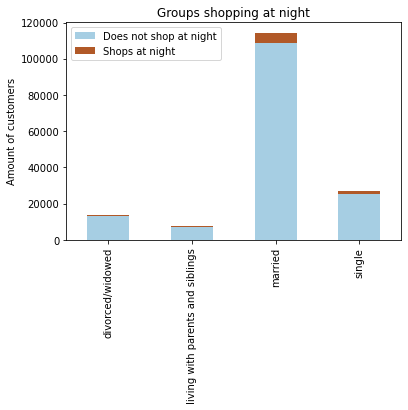

In [71]:
# Visualizing family groups that shop at night

marital_night = pd.crosstab(df_users.marital_status, df_users.late_night_shopper)
stacked_5 = marital_night.plot(kind = 'bar', stacked = True, title = 'Groups shopping at night', ylabel = 'Amount of customers', xlabel = '', colormap = 'Paired')
plt.legend(["Does not shop at night", "Shops at night"])

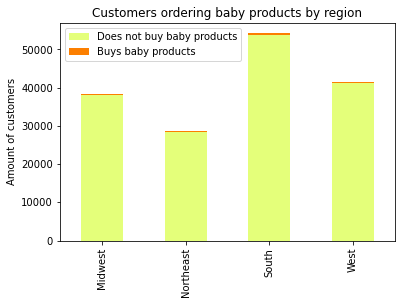

In [72]:
# Visualizing baby_household/region crosstab as stacked bar chart

region_age = pd.crosstab(df_users['region'], df_users['baby_household'])
stacked_6 = region_age.plot(kind = 'bar', stacked = True, title = 'Customers ordering baby products by region', ylabel = 'Amount of customers', xlabel = '', colormap = 'Wistia')
plt.legend(["Does not buy baby products", "Buys baby products"])

<AxesSubplot:xlabel='income', ylabel='median_order_frequency'>

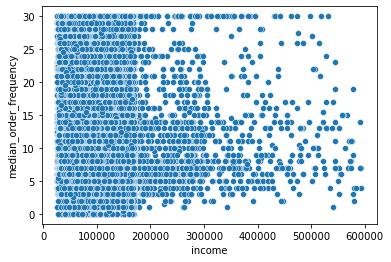

In [73]:
# Creating scatterplot to explore correlation between income and order frequency

sns.scatterplot(y = 'median_order_frequency', x = 'income', data = df_users)

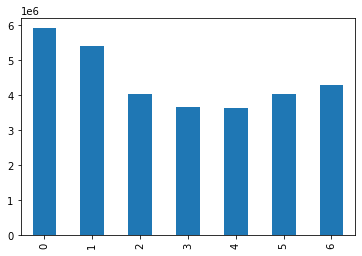

In [74]:
# Creating bar chart of total orders per weekday

bar_5 = df['order_day_of_week'].value_counts().sort_index().plot.bar()

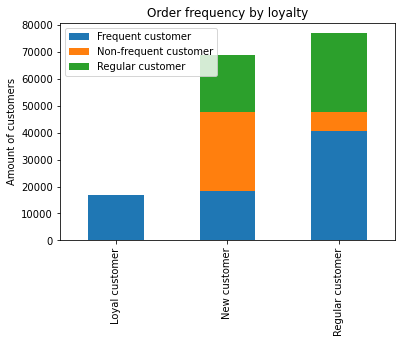

In [75]:
# Creating and visualizing crosstab of customer loyalty and order frequency

loyalty_frequency = pd.crosstab(df_users['loyalty_flag'], df_users['customer_frequency_flag'])
stacked_6 = loyalty_frequency.plot(kind = 'bar', stacked = True, title = 'Order frequency by loyalty', ylabel = 'Amount of customers', xlabel = '')
plt.legend(["Frequent customer", "Non-frequent customer", "Regular customer"])

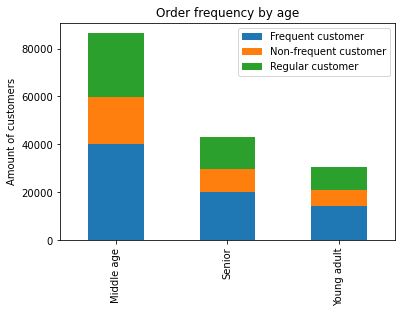

In [76]:
# Creating and visualizing crosstab of age group and customer frequency

age_frequency = pd.crosstab(df_users['age_group'], df_users['customer_frequency_flag'])
stacked_7 = age_frequency.plot(kind = 'bar', stacked = True, title = 'Order frequency by age', ylabel = 'Amount of customers', xlabel = '')
plt.legend(["Frequent customer", "Non-frequent customer", "Regular customer"])

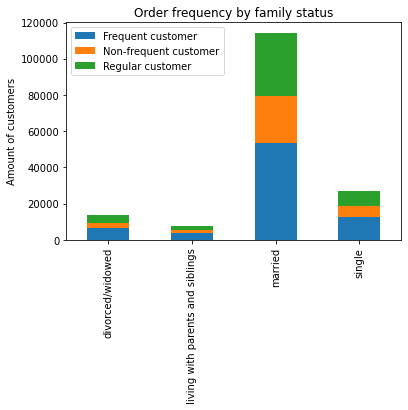

In [77]:
# Creating and visualizing crosstab of family status and customer frequency

family_frequency = pd.crosstab(df_users['marital_status'], df_users['customer_frequency_flag'])
stacked_8 = family_frequency.plot(kind = 'bar', stacked = True, title = 'Order frequency by family status', ylabel = 'Amount of customers', xlabel = '')
plt.legend(["Frequent customer", "Non-frequent customer", "Regular customer"])

In [78]:
df.head()

,order_id,user_id,order_number,order_day_of_week,order_hour_of_day,days_since_prior_order,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,prices,price_range_loc,busiest_day,busiest_day_2,busiest_period_of_day,max_order,loyalty_flag,spender_type,spending_flag,median_order_frequency,customer_frequency_flag,gender,state,age,date_joined,number_of_dependents,marital_status,income,department_name,region,income_bracket,age_group,dependent_status,baby_household,weekend_shopper,late_night_shopper
0,2539329,1,1,2,8,NaN,196,1,0,Soda,77.0,7.0,9.0,Mid range product,Regularly busy,Regular days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,beverages,South,Middle income,Middle age,Dependents,False,False,False
1,2539329,1,1,2,8,NaN,14084,2,0,Organic Unsweetened Vanilla Almond Milk,91.0,16.0,12.5,Mid range product,Regularly busy,Regular days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,dairy eggs,South,Middle income,Middle age,Dependents,False,False,False
2,2539329,1,1,2,8,NaN,12427,3,0,Original Beef Jerky,23.0,19.0,4.4,Low range product,Regularly busy,Regular days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,snacks,South,Middle income,Middle age,Dependents,False,False,False
3,2539329,1,1,2,8,NaN,26088,4,0,Aged White Cheddar Popcorn,23.0,19.0,4.7,Low range product,Regularly busy,Regular days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,snacks,South,Middle income,Middle age,Dependents,False,False,False
4,2539329,1,1,2,8,NaN,26405,5,0,XL Pick-A-Size Paper Towel Rolls,54.0,17.0,1.0,Low range product,Regularly busy,Regular days,Average orders,10,New customer,6.367797,Low spender,20.5,Non-frequent customer,Female,Alabama,31,2/17/2019,3,married,40423,household,South,Middle income,Middle age,Dependents,False,False,False


In [79]:
# Export charts to project folder

bar_1.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'income_bracket_profile.png'), bbox_inches = "tight")
bar_2.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'age_group_profile.png'), bbox_inches = "tight")
pie_1.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'dependent_status_profile.png'), bbox_inches = "tight")
pie_2.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'baby_household_profile.png'), bbox_inches = "tight")
pie_3.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'weekend_shopper_profile.png'), bbox_inches = "tight")
pie_4.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'late_night_profile.png'), bbox_inches = "tight")
bar_3.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'customers_by_region.png'), bbox_inches = "tight")
stacked_1.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'age_region_dist_stacked.png'), bbox_inches = "tight")
barh_1.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'sales_by_department.png'), bbox_inches = "tight")
bar_4.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'age_region_dist_bar.png'), bbox_inches = "tight")
stacked_2.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'order_frequency_region.png'), bbox_inches = "tight")
stacked_3.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'order_frequency_income.png'), bbox_inches = "tight")
barh_2.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'customers_weekend.png'), bbox_inches = "tight")
barh_3.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'customers_night.png'), bbox_inches = "tight")
stacked_4.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'groups_shopping_weekends.png'), bbox_inches = "tight")
stacked_5.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'groups_shopping_nights.png'), bbox_inches = "tight")
stacked_6.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'baby_households_region.png'),bbox_inches = "tight")
bar_5.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'orders_per_day.png'), bbox_inches = "tight")
stacked_6.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'order_frequency_by_loyalty.png'), bbox_inches = "tight")
stacked_7.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'order_frequency_by_age.png'), bbox_inches = "tight")
stacked_8.figure.savefig(os.path.join(path, '04 Analysis', 'Visualizations', 'order_frequency_by_family.png'), bbox_inches = "tight")

# 11. Exporting dataset

In [80]:
df.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'orders_products_all.pkl'))
df_users.to_pickle(os.path.join(path, '02 Data', 'Prepared Data', 'df_users410'))